# Image Classification: Pistachios

## MIDS W281: Computer Vision, Summer 2022

### Team members: Blake Bormes, Yu (Albert) Jiang, Deva Kulkarni

## Introduction

The focus of this project is to apply various computer vision techniques to classify images of pistachios. The dataset used in this project is made available on kaggle.com[1]. This dataset contains a total of 2148 images of two major types of pistachios grown in turkey, namely Kirmizi and Siirt. Since the prices, tastes, and nutritional values of these types differs, the type of pistachio becomes important when it comes to trade[2]. The dataset includes 1232 images of Kirmizi pistachios and 916 of Siirt Pistachios. 

The following report describes the Exploratory Data Analysis, Feature Extraction, Principal Component Analysis and Classification steps performed through the course of this project.



## Imports

In [1]:
#Importing libraries
import os
import math

import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import random
import seaborn as sns
from scipy.cluster.vq import vq
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy import spatial
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings('ignore')

## Load data

In [2]:
# csv file with pistachio names and labels
csv = pd.read_csv('pistachios_initial.csv', index_col = 0)

In [3]:
# pistachio_type 1 is Kirmizi, pistachio_type 0 is Siirt
csv.head()

,filename,filename_camelcase,pistachio_type
0,kirmizi (23).jpg,kirmizi_23.jpg,0
1,kirmizi 21.jpg,kirmizi_21.jpg,0
2,kirmizi 35.jpg,kirmizi_35.jpg,0
3,kirmizi 475.jpg,kirmizi_475.jpg,0
4,kirmizi 313.jpg,kirmizi_313.jpg,0


In [4]:
csv.pistachio_type.value_counts()

0    1232
1     916
Name: pistachio_type, dtype: int64

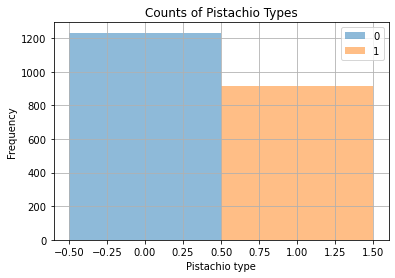

In [5]:
plt.hist(csv[csv.pistachio_type == 0].pistachio_type, bins = 1, alpha = 0.5, label = 0)
plt.hist(csv[csv.pistachio_type == 1].pistachio_type, bins = 1, alpha = 0.5, label = 1)
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('Pistachio type')
plt.ylabel('Frequency')
plt.title('Counts of Pistachio Types')
plt.show()

In [6]:
images = [] #list of images
fnames = []

for fname in csv.filename.values:
    if "kirm" in fname:
        fname = "Pistachio_Image_Dataset/Pistachio_Image_Dataset/Kirmizi_Pistachio/{}".format(fname)
    else:
        fname = "Pistachio_Image_Dataset/Pistachio_Image_Dataset/Siirt_Pistachio/{}".format(fname)
#     if "kirm" in fname:
#         fname = "Kirmizi_Pistachio/{}".format(fname)
#     else:
#         fname = "Siirt_Pistachio/{}".format(fname)
    images.append(plt.imread(fname))
    fnames.append(fname)

print('Total number of images: {}'.format(len(images)))
print('Shape of each image: {}'.format(images[0].shape))

Total number of images: 2148
Shape of each image: (600, 600, 3)


In [7]:
#print list of rand ints to use for kirmizi image index
random.sample(range(0, 1232), 5)

[824, 38, 441, 1093, 1016]

In [8]:
#print list of rand ints to use for siirt image index
random.sample(range(1232, 2148), 5)

[2018, 1749, 1547, 1929, 1847]

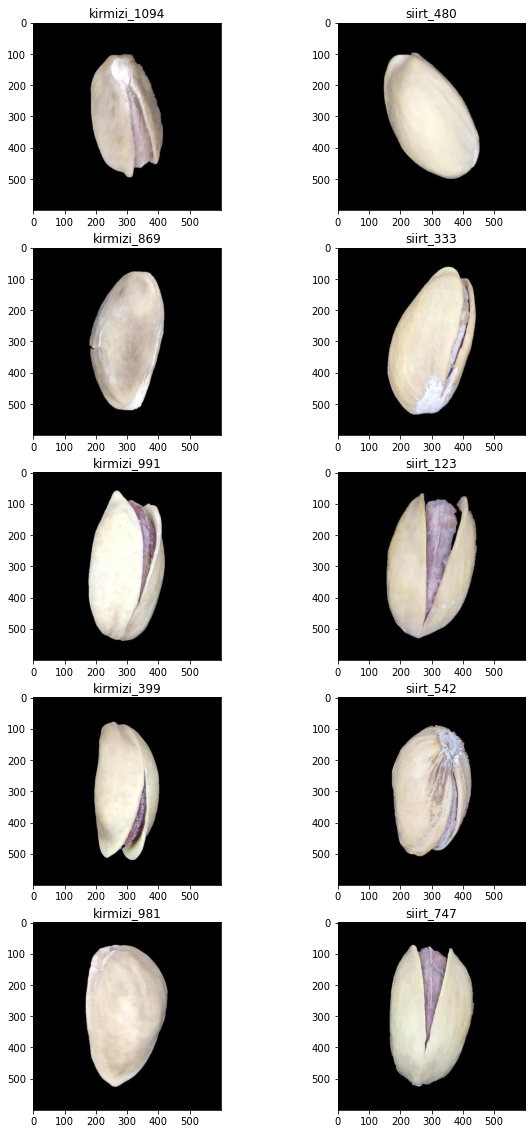

In [9]:
#Create list of random indexes to display random images
#Actually using random.randint gives differnet results for tsne later :/ )
random_image_index_kirmizi = [123, 234, 345, 456, 567]
random_image_index_siirt = [1234, 1345, 1456, 1567, 1678]


# Display examples images
fig, ax = plt.subplots(len(random_image_index_kirmizi),2, figsize = (10, 20))

for j, (index_0, index_1) in enumerate(zip(random_image_index_kirmizi, random_image_index_siirt)):
    
    ax[j, 0].imshow(images[index_0])
    ax[j, 0].set_title(csv.filename_camelcase[index_0][:-4])
    
    ax[j, 1].imshow(images[index_1])
    ax[j, 1].set_title(csv.filename_camelcase[index_1][:-4])      
        

Through simple visual inpsection, we see that Kirmizi pistachio (type 0) tend to be smaller than Siirt pistachios (type 1) on average. Kirmizi pistachios also tend to be longer and more slender than Siirt pistachios. There doesn't seem to be a clear difference in the shell or nut colors of the pistachios.

## EDA and Feature Extraction

- We look at the percentage of the image covered by the pistachio. We see that there is some separation between the two classes for this variable, with type 0 pistachios being slightly smaller than type 1 pistachios.

In [10]:
# Convert images to grayscale, and calculate the percentage area covered by the pistachio
grey_images = []
for img in images:
    grey_images.append(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))

percent_area = []
for img in grey_images:
    percent_area.append(np.count_nonzero(img)/(img.shape[0]*img.shape[1]))

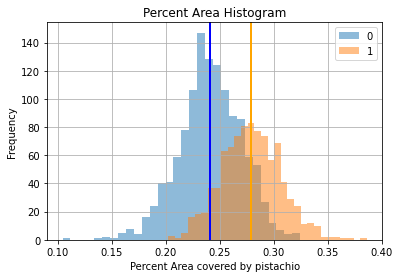

In [11]:
# Plot percent area for the two labels
csv['percent_area'] = percent_area

plt.hist(csv[csv.pistachio_type == 0].percent_area, bins = 30, alpha = 0.5, label = 0)
plt.hist(csv[csv.pistachio_type == 1].percent_area, bins = 30, alpha = 0.5, label = 1)
plt.axvline(csv[csv.pistachio_type == 0].percent_area.mean(), color='blue', linewidth=2)
plt.axvline(csv[csv.pistachio_type == 1].percent_area.mean(), color='orange', linewidth=2)
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('Percent Area covered by pistachio')
plt.ylabel('Frequency')
plt.title('Percent Area Histogram')
plt.show()

- We fit an ellipse to the outer edges of the pistachio image. Using the fitted ellipse, we calculate the major axis, minor axis, area and perimeter. We further use these parameters to calculate eccentricity, equivalent diameter, extent, aspect ratio, compactness, roundness and four other shape factors. 

- To identify these shape factors, first, we found the contour of the pistachio using a grayscale image of the pistachio to fit an ellipse around it.  From the ellipse, we were able to extract the lenght of the major and minor axes, and the area and perimeter of the ellipse.  We looked at both the area and perimeter values we get using provided cv2 contour functions along with the area and perimeter values we get from mathematical equations.  We found the area and perimeter values from the mathematical equations to be more consistent since the contour based values sometimes had odd outliers with very small values.
- Once we had the contour of the pistachio, we knew the coordinates inside the contour are the coordinates of the pistachio.  We then looked at both the RGB and HSV values of each pistachio coordinate to try and distinguish the pistacho's shell vs the pistachio's nut.  We fit a KMeans cluster model with three clusters to distinguish the shell vs the nut.  The most populous cluster identifies the shell, the second most populous cluster identifies the nut, and the third cluster mostly caught the boundary parts of the pistachio that were cut off from the background or hidden in shade.  
- After we distinguished the shell vs the nut components, we grabbed how many pixels were in each component, the mean and median of each RGB and HSV element in each component, and the mean and median of each RGB and HSV element in samples of 100 random pixels of each component.  We tried to look at median and the samples of 100 random samples to lessen the impact of misclassified pixels.  Ultimately, we don't expect most of the extra features to yield much predictive power after a PCA cleans most of them up.
- We noted that in the cases where the pistachio's nut was not visible at all, it essentially got random low values that were similar to the third cluster when the nut is visible.

In [12]:
# process function
def process_ellipse(fname):
    # read input
    img = cv2.imread(fname)

    # convert to gray
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # threshold
    thresh = cv2.threshold(gray, 100 , 255, cv2.THRESH_BINARY)[1]

    # find largest contour
    contours = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[0] if len(contours) == 2 else contours[1]
    big_contour = max(contours, key=cv2.contourArea)

    # fit contour to ellipse and get ellipse center, minor and major diameters and angle in degree 
    ellipse = cv2.fitEllipse(big_contour)
    (xc,yc),(d1,d2),angle = ellipse

    # draw ellipse
    result = img.copy()
    cv2.ellipse(result, ellipse, (0, 255, 0), 3)

    # draw circle at center
    xc, yc = ellipse[0]
    cv2.circle(result, (int(xc),int(yc)), 10, (255, 0, 0), 20)

    # draw vertical line
    # compute major radius
    rmajor = max(d1,d2)/2
    if angle > 90:
        angle = angle - 90
    else:
        angle = angle + 90

    xtop_major = xc + math.cos(math.radians(angle))*rmajor
    ytop_major = yc + math.sin(math.radians(angle))*rmajor
    xbot_major = xc + math.cos(math.radians(angle+180))*rmajor
    ybot_major = yc + math.sin(math.radians(angle+180))*rmajor
    cv2.line(result, (int(xtop_major),int(ytop_major)), (int(xbot_major),int(ybot_major)), (0, 0, 255), 3)
    major_distance = ((xtop_major - xbot_major)**2 + (ytop_major - ybot_major)**2)**0.5

    # draw vertical line
    # compute minor radius
    rminor = min(d1,d2)/2
    if angle > 90:
        angle = angle - 90
    else:
        angle = angle + 90

    xtop_minor = xc + math.cos(math.radians(angle))*rminor
    ytop_minor = yc + math.sin(math.radians(angle))*rminor
    xbot_minor = xc + math.cos(math.radians(angle+180))*rminor
    ybot_minor = yc + math.sin(math.radians(angle+180))*rminor
    cv2.line(result, (int(xtop_minor),int(ytop_minor)), (int(xbot_minor),int(ybot_minor)), (0, 0, 255), 3)
    minor_distance = ((xtop_minor - xbot_minor)**2 + (ytop_minor - ybot_minor)**2)**0.5
    
    major_radius = major_distance/2
    minor_radius = minor_distance/2
    ellipse_area = np.pi * major_radius * minor_radius
    ellipse_perimeter = 2 * np.pi * ((major_radius ** 2 + minor_radius ** 2)/2) ** 0.5
    cv2.imwrite(fname.replace("/", "_processed/"), result)
    
    # Extract Color data
    
    cnt = contours[0]
    area = cv2.contourArea(cnt)
    perimeter = cv2.arcLength(cnt,True)

    rgb_im = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    hsv_im = cv2.cvtColor(rgb_im, cv2.COLOR_RGB2HSV)

    pistachio_cords = np.argwhere(gray > 0)
    pistachio_pixs = rgb_im[pistachio_cords[:, 0], pistachio_cords[:, 1]]
    pistachio_hsv = hsv_im[pistachio_cords[:, 0], pistachio_cords[:, 1]]

    X = pistachio_hsv.reshape(-1, 3)
    kmeans = KMeans(n_clusters=3, random_state=0).fit(X)
    results = kmeans.labels_

    unique, counts = np.unique(results, return_counts=True)
    argsort = unique[np.argsort(counts)]
    shell = unique[argsort[2]]
    shell_count = counts[argsort[2]]
    nut = unique[argsort[1]]
    nut_count = counts[argsort[1]]

    shell_cords = pistachio_cords[np.argwhere(results == shell).flatten()]
    nut_cords = pistachio_cords[np.argwhere(results == nut).flatten()]

    shell_pixs = rgb_im[shell_cords[:, 0], shell_cords[:, 1]]
    shell_hsv = hsv_im[shell_cords[:, 0], shell_cords[:, 1]]
    nut_pixs = rgb_im[nut_cords[:, 0], nut_cords[:, 1]]
    nut_hsv = hsv_im[nut_cords[:, 0], nut_cords[:, 1]]

    shell_pixs_mean, nut_pixs_mean, shell_pixs_med, nut_pixs_med, \
    shell_r_mean, shell_g_mean, shell_b_mean, \
    nut_r_mean, nut_g_mean, nut_b_mean, \
    shell_r_med, shell_g_med, shell_b_med, \
    nut_r_med, nut_g_med, nut_b_med, \
    shell_h_mean, shell_s_mean, shell_v_mean, \
    nut_h_mean, nut_s_mean, nut_v_mean, \
    shell_h_median, shell_s_median, shell_v_median, \
    nut_h_median, nut_s_median, nut_v_median = _get_mean_med_helper(shell_pixs, shell_hsv, nut_pixs, nut_hsv)

    n = 100
    random_shell_indices = np.random.choice(len(shell_cords), size=n, replace=False)
    random_nut_indices = np.random.choice(len(nut_cords), size=n, replace=False)
    n_shell_cords = shell_cords[random_shell_indices, :]
    n_nut_cords = nut_cords[random_nut_indices, :]

    n_shell_pixs = rgb_im[n_shell_cords[:, 0], n_shell_cords[:, 1]]
    n_shell_hsv = hsv_im[n_shell_cords[:, 0], n_shell_cords[:, 1]]
    n_nut_pixs = rgb_im[n_nut_cords[:, 0], n_nut_cords[:, 1]]
    n_nut_hsv = hsv_im[n_nut_cords[:, 0], n_nut_cords[:, 1]]

    n_shell_pixs_mean, n_nut_pixs_mean, n_shell_pixs_med, n_nut_pixs_med, \
    n_shell_r_mean, n_shell_g_mean, n_shell_b_mean, \
    n_nut_r_mean, n_nut_g_mean, n_nut_b_mean, \
    n_shell_r_med, n_shell_g_med, n_shell_b_med, \
    n_nut_r_med, n_nut_g_med, n_nut_b_med, \
    n_shell_h_mean, n_shell_s_mean, n_shell_v_mean, \
    n_nut_h_mean, n_nut_s_mean, n_nut_v_mean, \
    n_shell_h_median, n_shell_s_median, n_shell_v_median, \
    n_nut_h_median, n_nut_s_median, n_nut_v_median = _get_mean_med_helper(n_shell_pixs, n_shell_hsv, n_nut_pixs, n_nut_hsv)
    
    rgb_im[shell_cords[:, 0], shell_cords[:, 1]] = np.array([0, 0, 255])
    rgb_im[nut_cords[:, 0], nut_cords[:, 1]] = np.array([255, 0, 0])
    cv2.imwrite(fname.replace("/", "_shell_nut/"), rgb_im) # actually saves shell as red because saving uses bgr

    return major_distance, minor_distance, \
    area, perimeter, \
    ellipse_area, ellipse_perimeter, \
    shell_count, nut_count, \
    shell_pixs_mean, nut_pixs_mean, shell_pixs_med, nut_pixs_med, \
    shell_r_mean, shell_g_mean, shell_b_mean, \
    nut_r_mean, nut_g_mean, nut_b_mean, \
    shell_r_med, shell_g_med, shell_b_med, \
    nut_r_med, nut_g_med, nut_b_med, \
    shell_h_mean, shell_s_mean, shell_v_mean, \
    nut_h_mean, nut_s_mean, nut_v_mean, \
    shell_h_median, shell_s_median, shell_v_median, \
    nut_h_median, nut_s_median, nut_v_median, \
    n_shell_pixs_mean, n_nut_pixs_mean, n_shell_pixs_med, n_nut_pixs_med, \
    n_shell_r_mean, n_shell_g_mean, n_shell_b_mean, \
    n_nut_r_mean, n_nut_g_mean, n_nut_b_mean, \
    n_shell_r_med, n_shell_g_med, n_shell_b_med, \
    n_nut_r_med, n_nut_g_med, n_nut_b_med, \
    n_shell_h_mean, n_shell_s_mean, n_shell_v_mean, \
    n_nut_h_mean, n_nut_s_mean, n_nut_v_mean, \
    n_shell_h_median, n_shell_s_median, n_shell_v_median, \
    n_nut_h_median, n_nut_s_median, n_nut_v_median 

def _get_mean_med_helper(shell_pixs, shell_hsv, nut_pixs, nut_hsv):
    return [shell_pixs.mean(), nut_pixs.mean(), np.median(shell_pixs), np.median(nut_pixs)] + \
list(shell_pixs.mean(axis=0)) + list(nut_pixs.mean(axis=0)) + \
list(np.median(shell_pixs, axis=0)) + list(np.median(nut_pixs, axis=0)) + \
list(shell_hsv.mean(axis=0)) + list(nut_hsv.mean(axis=0)) + \
list(np.median(shell_hsv, axis=0)) + list(np.median(nut_hsv, axis=0))

FileNotFoundError: [Errno 2] No such file or directory: 'Pistachio_Image_Dataset_processed/Pistachio_Image_Dataset_processed/Kirmizi_Pistachio_processed/kirmizi 1094.jpg'

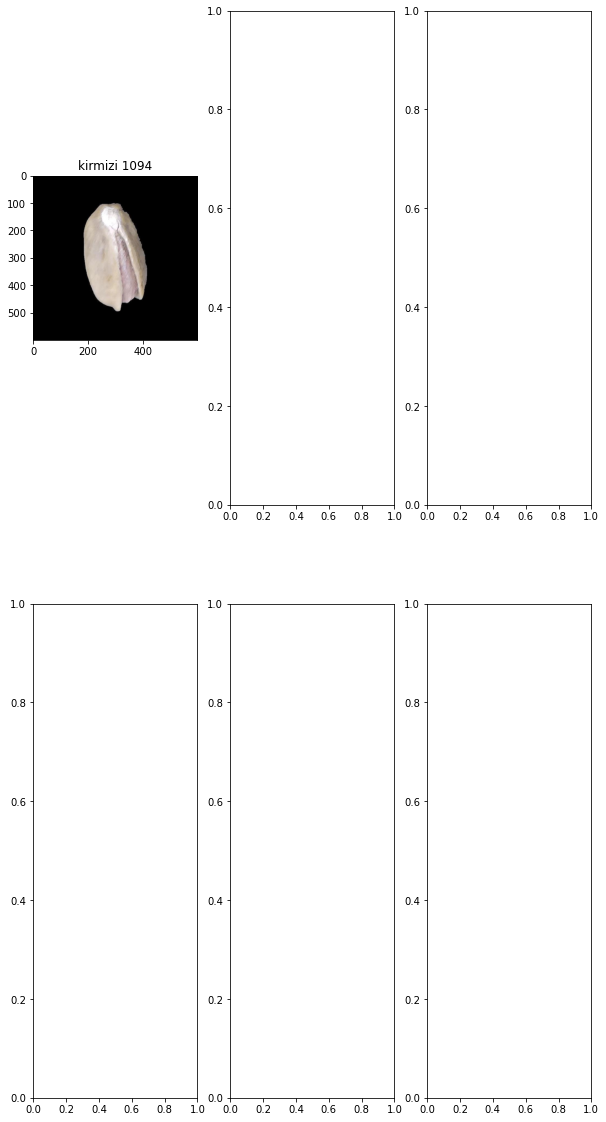

In [13]:
# get random image and filepaths
random_kirmizi_index = random_image_index_kirmizi[0]
random_siirt_index = random_image_index_siirt[0]

random_kirmizi_image = images[random_kirmizi_index]
random_siirt_image = images[random_siirt_index]

random_kirmizi_fname = fnames[random_kirmizi_index]
random_siirt_fname = fnames[random_siirt_index]

random_kirmizi_name = random_kirmizi_fname.split("/")[-1][:-4]
random_siirt_name = random_siirt_fname.split("/")[-1][:-4]

process_ellipse(random_kirmizi_fname)
process_ellipse(random_siirt_fname)

# Display examples images
fig, axs = plt.subplots(2, 3, figsize = (10, 20))
    
axs[0, 0].imshow(random_kirmizi_image)
axs[0, 0].set_title(random_kirmizi_name)

random_kirmizi_image_processed = plt.imread(random_kirmizi_fname.replace("/", "_processed/"))
axs[0, 1].imshow(random_kirmizi_image_processed)
axs[0, 1].set_title("{} Ellipse".format(random_kirmizi_name))    

random_kirmizi_image_shell_nut = plt.imread(random_kirmizi_fname.replace("/", "_shell_nut/"))
axs[0, 2].imshow(random_kirmizi_image_shell_nut)
axs[0, 2].set_title("{} Shell Nut".format(random_kirmizi_name))    

axs[1, 0].imshow(random_siirt_image)
axs[1, 0].set_title(random_siirt_name)

random_siirt_image_processed = plt.imread(random_siirt_fname.replace("/", "_processed/"))
axs[1, 1].imshow(random_siirt_image_processed)
axs[1, 1].set_title("{} Ellipse".format(random_siirt_name))    

random_siirt_image_shell_nut = plt.imread(random_siirt_fname.replace("/", "_shell_nut/"))
axs[1, 2].imshow(random_siirt_image_shell_nut)
axs[1, 2].set_title("{} Shell Nut".format(random_siirt_name))    

_ = fig.suptitle("Features Visualization Example")

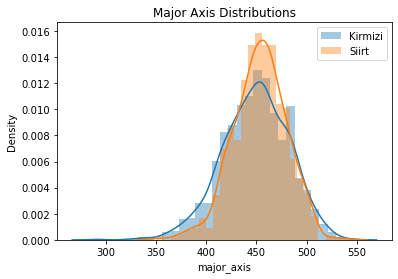

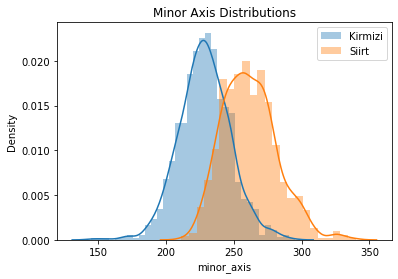

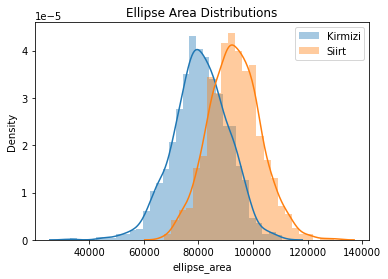

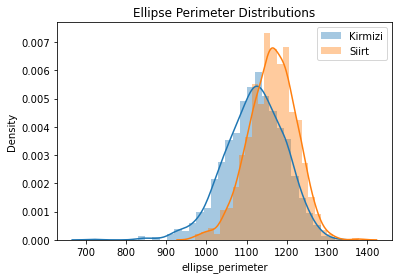

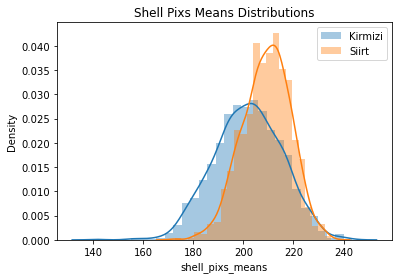

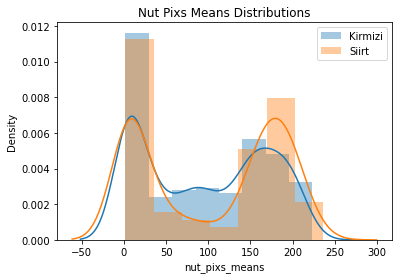

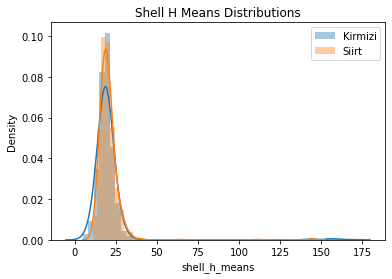

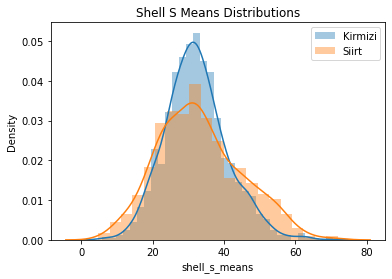

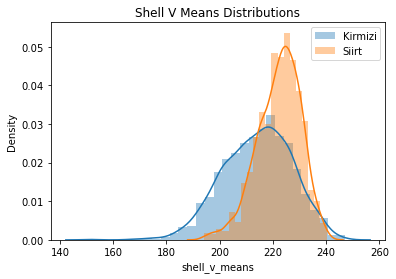

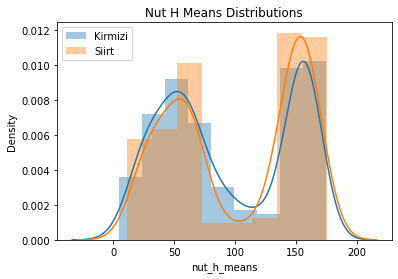

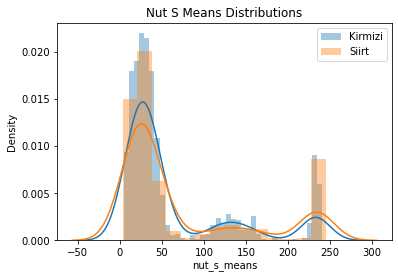

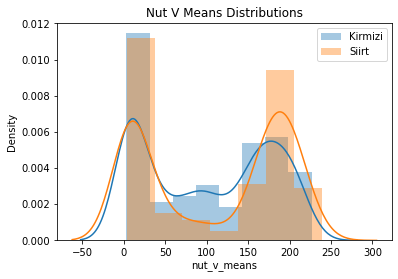

In [33]:
df = pd.read_csv("pistachios.csv", index_col=0)
k = df.loc[df["pistachio_type"] == 0]
s = df.loc[df["pistachio_type"] == 1]

columns = [
    "major_axis", 
    "minor_axis", 
    "ellipse_area", 
    "ellipse_perimeter", 
    "shell_pixs_means", 
    "nut_pixs_means", 
    "shell_h_means", 
    "shell_s_means", 
    "shell_v_means", 
    "nut_h_means", 
    "nut_s_means", 
    "nut_v_means"]
for c in columns:
    ax = sns.distplot(k[c], label="Kirmizi")
    ax.set_title("{} Distributions".format((" ".join(c.split("_"))).title()))
    sns.distplot(s[c], label="Siirt")
    plt.legend()
    plt.show()

- To quantify the fit of the ellipse to the outer edges of the pisatchio, we calculate the distance of each point on the pistachio edge from the fitted ellipse. The final feature is the sum of all the distances for each pistachio scaled by the perimeter of the ellipse.

In [34]:
#Rescale and blur
rescaled_images = []
for img in grey_images:
    rescaled_images.append(cv2.GaussianBlur(cv2.resize(img, (200, 200)), (9, 9), 0))

def fit_ellipse(img):
    '''This function takes in an image of a pistachio and fits an ellipse to its outer edges.
    '''
    out_img = img.copy()            
    
    try:
        ret,thresh = cv2.threshold(out_img,5,255,0)
        contours,hierarchy = cv2.findContours(thresh, 1, 2) 
        cnt = contours[-1]
        area = cv2.contourArea(cnt)
        perimeter = cv2.arcLength(cnt,True)
        ellipse = cv2.fitEllipse(cnt)
        return cv2.ellipse(out_img,ellipse,(255),2), cv2.ellipse(np.zeros_like(out_img),ellipse,(255),1), ellipse

    except cv2.error as e:
        pass

#Fit ellipse
ellipse_images = []
for img in rescaled_images:
    ellipse_images.append(fit_ellipse(img))
    
#Detect edges
def whiten_image(img):
    '''Take a rescaled and blurred image of pistachio, blow up pistachio to white,
    detect edges and return.
    '''    
    out_img = img.copy()
    out_img = np.where(out_img > 5, 255, 0).astype('uint8')
    return cv2.Canny(out_img, 100, 200)

white_patch_edge_detect = []
for img in rescaled_images:
    white_patch_edge_detect.append(whiten_image(img))


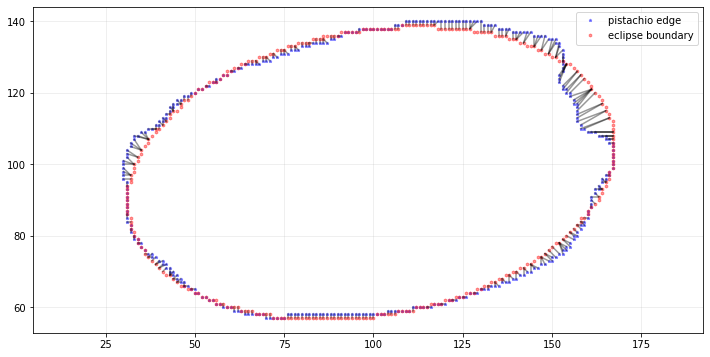

In [35]:
# Detect pistachio edge
pistachio_edge = np.argwhere(white_patch_edge_detect[random_image_index_kirmizi[0]] == 255)

# Detect ellipse 
ellipse_boundary = np.argwhere(ellipse_images[random_image_index_kirmizi[0]][1] == 255)

# For each point in pistachio_edge, find the closest point in ellipse_boundary:
code, dist = vq(pistachio_edge, ellipse_boundary)

fig = plt.gcf()
fig.set_size_inches(12, 6)

plt.plot(pistachio_edge[:,0], pistachio_edge[:,1], 'b*', markersize=3, alpha=0.4, label = 'pistachio edge')
plt.plot(ellipse_boundary[:,0], ellipse_boundary[:,1], 'rh', markersize=3, alpha=0.4, label = 'eclipse boundary')

for i, j in enumerate(code):
    plt.plot([pistachio_edge[i,0], ellipse_boundary[j,0]],
             [pistachio_edge[i,1], ellipse_boundary[j,1]], 'k', alpha=0.4)
plt.legend()
plt.grid(True, alpha=0.25)
plt.axis('equal')
plt.show()

In [36]:
def calculate_distance(ellipse_img, edge_img):
    '''This function calcualtes the minimum distance between points on 
    the edge image and points on the ellipse image. Returns total distance normalized by ellipse perimeter
    '''
    edge_points = np.argwhere(edge_img == 255)
    ellipse_points = np.argwhere(ellipse_img[1] == 255)
    code, dist = vq(edge_points, ellipse_points)
    return dist.sum()/calculate_perimeter(ellipse_img[2][1][0], ellipse_img[2][1][1])
    
def calculate_perimeter(a,b):
    perimeter = np.pi * ( 3*(a+b) - np.sqrt( (3*a + b) * (a + 3*b) ) )
    return perimeter

In [37]:
distance_from_ellipse = []
for i in range(len(images)):
    try:
        distance_from_ellipse.append(calculate_distance(ellipse_images[i], white_patch_edge_detect[i]))
    except:
        print(i)
        distance_from_ellipse.append(np.nan)

In [38]:
csv['distance_from_ellipse'] = distance_from_ellipse

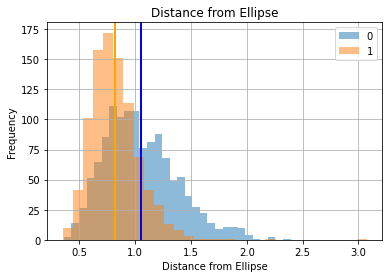

In [39]:
plt.hist(csv[csv.pistachio_type == 0].distance_from_ellipse, bins = 30, alpha = 0.5, label = 0)
plt.hist(csv[csv.pistachio_type == 1].distance_from_ellipse, bins = 30, alpha = 0.5, label = 1)
plt.legend(loc='upper right')
plt.axvline(csv[csv.pistachio_type == 0].distance_from_ellipse.mean(), color='blue', linewidth=2)
plt.axvline(csv[csv.pistachio_type == 1].distance_from_ellipse.mean(), color='orange', linewidth=2)
plt.grid()
plt.xlabel('Distance from Ellipse')
plt.ylabel('Frequency')
plt.title('Distance from Ellipse')
plt.show()

We see that the distance of ellipse parameter does show some separation between the two classes. The ellipses tend to fit better for type 1 pistachios than type 2 pistachios on average.

- Finally, we added several features based on [this paper](https://www.mattioli1885journals.com/index.php/progressinnutrition/article/view/9686/9178) that essentially applies various mathematical transforms to a combination of some of the previous features to get additional shape related features.  We expect some of these features, like aspect ratio which is the major axis divided by the minor axis, to actually yield some additional predictive power because they are interactions of multiple variables.  However, we expected most to all of them to be washed out after the PCA since they seem to duplicate various interactions, just with different scaling factors.  

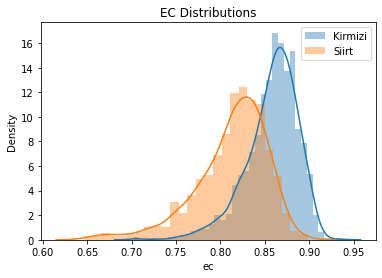

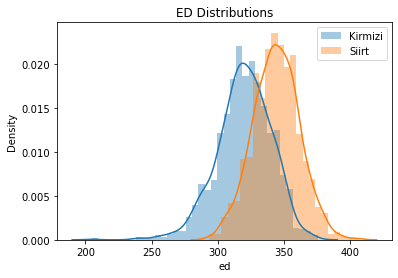

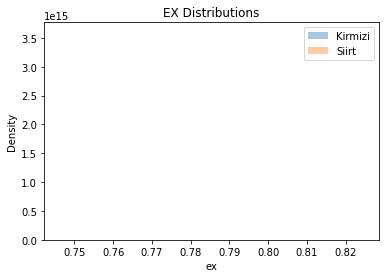

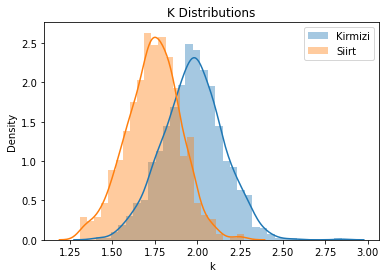

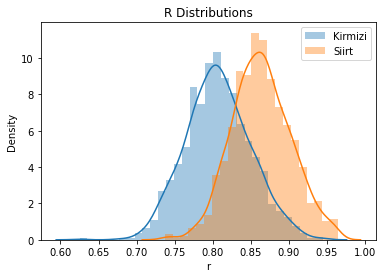

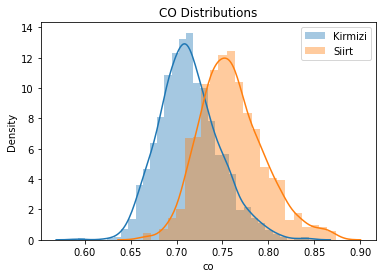

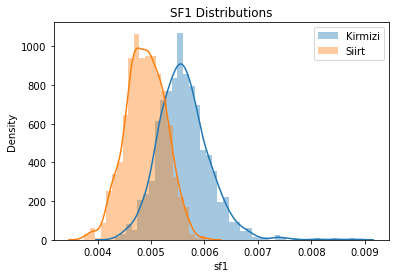

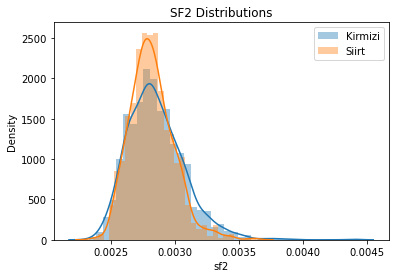

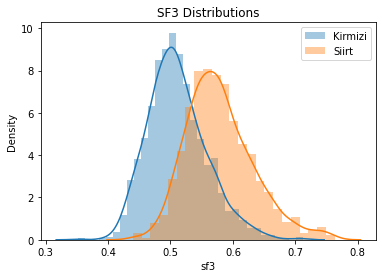

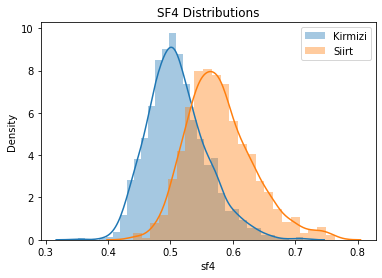

In [40]:
df["ec"] = np.sqrt(1 - df["minor_axis"] ** 2/df["major_axis"] ** 2)
df["ed"] = np.sqrt(4 * df["ellipse_area"]/np.pi)
df["ex"] = df["ellipse_area"]/df["major_axis"]/df["minor_axis"]
df["k"] = df["major_axis"]/df["minor_axis"]
df["r"] = 4 * np.pi * df["ellipse_area"]/df["ellipse_perimeter"] ** 2
df["co"] = df["ed"]/df["major_axis"]
df["sf1"] = df["major_axis"]/df["ellipse_area"]
df["sf2"] = df["minor_axis"]/df["ellipse_area"]
df["sf3"] = df["ellipse_area"]/(df["major_axis"] ** 2 * 1/4 * np.pi)
df["sf4"] = df["ellipse_area"]/(df["major_axis"]/2 * df["major_axis"]/2 * np.pi)

columns = [
    "ec", 
    "ed", 
    "ex", 
    "k", 
    "r", 
    "co", 
    "sf1", 
    "sf2", 
    "sf3", 
    "sf4"]
for c in columns:
    ax = sns.distplot(k[c], label="Kirmizi")
    ax.set_title("{} Distributions".format(c.upper()))
    sns.distplot(s[c], label="Siirt")
    plt.legend()
    plt.show()

### PCA analysis

In [41]:
#Importing hand coded and learned features from saved csv files.

# check if train, val, and test data already exist
if os.path.exists("pistachios_with_cnn_train.csv"):
    # if so, read them directly
    X_train = pd.read_csv("pistachios_with_cnn_train.csv", index_col=0)
    y_train = pd.read_csv("pistachios_with_cnn_train_labels.csv", index_col=0, squeeze=True)
    X_val = pd.read_csv("pistachios_with_cnn_val.csv", index_col=0)
    y_val = pd.read_csv("pistachios_with_cnn_val_labels.csv", index_col=0, squeeze=True)
    X_test = pd.read_csv("pistachios_with_cnn_test.csv", index_col=0)
    y_test = pd.read_csv("pistachios_with_cnn_test_labels.csv", index_col=0, squeeze=True)
else:
    # otherwise, read in the main data frame and split into train, val, and test
    if os.path.exists("pistachios_with_cnn.csv"):
        df = pd.read_csv("pistachios_with_cnn.csv", index_col=0)
    else:
        df = pd.read_csv("pistachios.csv", index_col=0)
        tmp = pd.read_csv("second_last_layer_final.csv", index_col=0)
        df = pd.concat([df, tmp], axis=1)
        df.to_csv("pistachios_with_cnn.csv")

        X = df[df.columns[3:]]
        y = df["pistachio_type"]
        X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
        X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=0)

        # save train, val, and test for future use
        X_train.to_csv("pistachios_with_cnn_train.csv")
        y_train.to_csv("pistachios_with_cnn_train_labels.csv")
        X_val.to_csv("pistachios_with_cnn_val.csv")
        y_val.to_csv("pistachios_with_cnn_val_labels.csv")
        X_test.to_csv("pistachios_with_cnn_test.csv")
        y_test.to_csv("pistachios_with_cnn_test_labels.csv")

# separate hand coded features from the cnn features for train, val, and test
X_train_cnn = X_train[X_train.columns[-8:]].copy()
X_val_cnn = X_val[X_val.columns[-8:]].copy()
X_test_cnn = X_test[X_test.columns[-8:]].copy()
X_train.drop(X_train.columns[-8:], inplace=True, axis=1)
X_val.drop(X_val.columns[-8:], inplace=True, axis=1)
X_test.drop(X_test.columns[-8:], inplace=True, axis=1)

In [42]:
X_train_index = X_train.index
X_val_index = X_val.index
X_test_index = X_test.index

In [43]:
X_train_columns = X_train.columns
X_train_columns_cnn = X_train_cnn.columns

In [44]:
# use standard scaler to rescale by running fit and transform on hand coded train features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
# apply the same transform to val and test
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

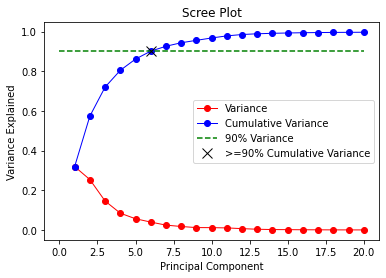

In [45]:
# define PCA model to use on hand coded features
n = 20
pca = PCA(n_components=n)

# fit PCA model
X_train = pca.fit_transform(X_train)
# get cumulative sum of variance and find the dimensions cutoff where we first reach >= 90% variance
cum_sum = np.cumsum(pca.explained_variance_ratio_)
cutoff = np.argwhere(cum_sum >= 0.9)[0][0] + 1

# plot scree plot with variance, cumulative variance, and cutoff
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=1, color='red', label="Variance")
plt.plot(PC_values, cum_sum, 'o-', linewidth=1, color='blue', label="Cumulative Variance")
plt.plot([0, n], [0.9, 0.9], "g--", label="90% Variance")
plt.plot(cutoff, cum_sum[cutoff - 1], "kx", label=">=90% Cumulative Variance", markersize=10)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.legend()
plt.show()

# limit train, val, and test hand coded PCA features up to the first cutoff dimensions
X_train = X_train[:, :cutoff]
X_val = pca.transform(X_val)[:, :cutoff]
X_test = pca.transform(X_test)[:, :cutoff]

In [46]:
np.set_printoptions(linewidth=np.inf)
# Looking at which features contribute most to the first 6 PCA components
ind = np.flip((np.argsort(np.abs(pca.components_[0:6,:]))), axis = 1)

print('Features that contribute the most to 1st PCA component:')
print((X_train_columns[ind[0,:5]]).values)
print('')

print('Features that contribute the most to 2nd PCA component:')
print((X_train_columns[ind[1,:5]]).values)
print('')

print('Features that contribute the most to 3rd PCA component:')
print((X_train_columns[ind[2,:5]]).values)
print('')

print('Features that contribute the most to 4th PCA component:')
print((X_train_columns[ind[3,:5]]).values)
print('')

print('Features that contribute the most to 5th PCA component:')
print((X_train_columns[ind[4,:5]]).values)
print('')

print('Features that contribute the most to 6th PCA component:')
print((X_train_columns[ind[5,:5]]).values)
print('')

Features that contribute the most to 1st PCA component:
['nut_b_means' 'n_nut_b_means' 'nut_v_means' 'nut_pixs_means' 'n_nut_v_means']

Features that contribute the most to 2nd PCA component:
['shell_pixs_means' 'n_shell_pixs_means' 'shell_g_means' 'shell_pixs_meds' 'n_shell_g_means']

Features that contribute the most to 3rd PCA component:
['percent_area' 'minor_axes' 'minor_axis' 'sf1' 'ellipse_areas']

Features that contribute the most to 4th PCA component:
['major_axis' 'major_axes' 'sf2' 'r' 'k']

Features that contribute the most to 5th PCA component:
['shell_h_means' 'n_shell_h_means' 'shell_h_medians' 'n_shell_h_medians' 'shell_s_medians']

Features that contribute the most to 6th PCA component:
['n_shell_s_means' 'shell_s_means' 'n_shell_s_medians' 'shell_s_medians' 'n_shell_h_medians']



- We only need 6 PCA features to explain 90% of variance
- The major contributors to the first PCA component are features related to means of the Blue color channel and the Value parameter in the HSV color scale for the pistachio nut.

- Subsequent PCA components contain features related to the shell colors the pistachio shape such as shape factors, eccentricity, aspect ratio and major and minor axis.

- This is expected because we see a large variance in the colors of the pistachio nuts, including some pistachios where the nut is not visible in the image. Some variance is seen in the shell colors, ranging from a bright white to a dull gray. The parameters of the fitted ellipse, in comparison, do not have as much variance across pistachios.

### TSNE analysis

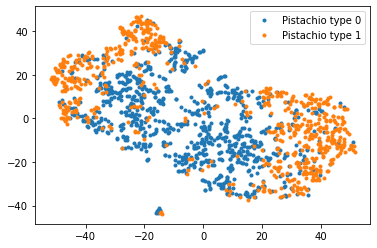

In [73]:
# use tSNE to plot hand coded train features after PCA dimensionality reduction in 2D
tsne = TSNE(n_components=2, random_state=0)
# rescale train PCA data so tSNE can treat dimensions with equal importance
tsne_X = tsne.fit_transform(scaler.fit_transform(X_train))
# plot tSNE of rescaled train PCA data
tsne_plot_x = tsne_X[:, 0]
tsne_plot_y = tsne_X[:, 1]
check_x_0 = tsne_plot_x[y_train == 0]
check_y_0 = tsne_plot_y[y_train == 0]
check_x_1 = tsne_plot_x[y_train == 1]
check_y_1 = tsne_plot_y[y_train == 1]
plt.plot(check_x_0, check_y_0, ".", label = 'Pistachio type 0')
plt.plot(check_x_1, check_y_1, ".", label = 'Pistachio type 1')
plt.legend()

- From the TSNE visualization of the first 6 PCA components, we see that there is some degree of separation between the two classes. Pistachio type 0 tends to be near the center of the plot while, pistachio type 1 tends to be at the either ends, though there is an appreciable overlap. There is also an interesting cluster of both classes at location ~(-40, -20) outside the general population.

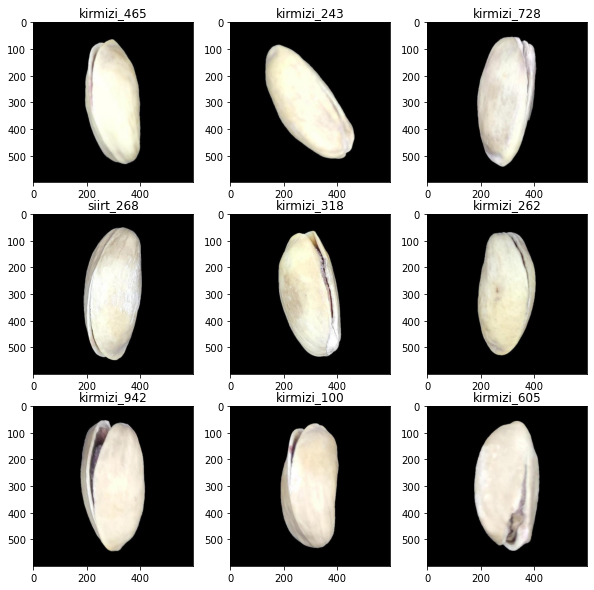

In [77]:
# Looking at 9 pistachios that end up closest to (-40, -12) in the tsne plot
tsne_coords = np.vstack([tsne_plot_x, tsne_plot_y])
pt = [-40, -12]
kdtree_ind = spatial.KDTree(tsne_coords.T).query(pt, k = 9)[1]

# Display examples images
fig, ax = plt.subplots(len(X_train_index[kdtree_ind])//3,3, figsize = (10, 10))

for j in range(0, 9, 3):
    ax[j//3, 0].imshow(images[X_train_index[kdtree_ind][j]])
    ax[j//3, 0].set_title(csv.filename_camelcase[kdtree_ind[j]][:-4])
    ax[j//3, 1].imshow(images[X_train_index[kdtree_ind][j+1]])
    ax[j//3, 1].set_title(csv.filename_camelcase[kdtree_ind[j+1]][:-4])
    ax[j//3, 2].imshow(images[X_train_index[kdtree_ind][j+2]])
    ax[j//3, 2].set_title(csv.filename_camelcase[kdtree_ind[j+2]][:-4])   
 

- The ouliers are pistachios with a purple-ish hue in the shell color. As seen previously, the largest contributions to the PCA components were by the pixel values in the blue channel of the images, hence, Pistachio with peculiar colors get separated from the main population. These may need to be treated separately based on further investigation.

### Logistic Regression of Features

In [49]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [50]:
# Use ‘sag’ and ‘saga’ solvers which are faster for large datasets
# ‘sag’ is supported by the following penalties [‘l2’, ‘none’]
# ‘saga’ is supported by the following penalties [‘l1’, ‘l2’, ‘none’]
solvers = ['sag','saga']

for i in solvers:
    if i == 'sag':
        logreg_sag_l2 = LogisticRegression(penalty = 'l2', solver = i)
        logreg_sag_l2.fit(X_train, y_train)
        validation_score_sag_l2 = logreg_sag_l2.score(X_val, y_val)
        logreg_sag_none = LogisticRegression(penalty = 'none', solver = i)
        logreg_sag_none.fit(X_train, y_train)
        validation_score_sag_none = logreg_sag_none.score(X_val, y_val)
    else:
        logreg_saga_l1 = LogisticRegression(penalty = 'l1', solver = i)
        logreg_saga_l1.fit(X_train, y_train)
        validation_score_saga_l1 = logreg_saga_l1.score(X_val, y_val)
        logreg_saga_l2 = LogisticRegression(penalty = 'l2', solver = i)
        logreg_saga_l2.fit(X_train, y_train)
        validation_score_saga_l2 = logreg_saga_l2.score(X_val, y_val)
        logreg_saga_none = LogisticRegression(penalty = 'none', solver = i)
        logreg_saga_none.fit(X_train, y_train)
        validation_score_saga_none = logreg_saga_none.score(X_val, y_val)
print(f"Validation set score for Sag solver and L2 penalty: {round(validation_score_sag_l2*100,2)}%. \n Validation set scor for Sag solver and none penalty: {round(validation_score_sag_none*100,2)}%. \n Validation set score for Saga solver and L2 penalty: {round(validation_score_saga_l1*100,2)}%. \nValidation set score for Saga solver and L2 penalty: {round(validation_score_saga_l2*100,2)}%. \n Validation set score for Saga solver and none penalty: {round(validation_score_saga_none*100,2)}%.")   

Validation set score for Sag solver and L2 penalty: 81.4%. 
 Validation set scor for Sag solver and none penalty: 81.4%. 
 Validation set score for Saga solver and L2 penalty: 81.65%. 
Validation set score for Saga solver and L2 penalty: 81.4%. 
 Validation set score for Saga solver and none penalty: 81.4%.


In [51]:
# Use Saga solver with L2 penalty on Test data
# init and fit logistic regression model to train PCA data
logreg = LogisticRegression(penalty = 'l2', solver = 'saga')
logreg.fit(X_train, y_train)

# print training and validation scores and classification metrics
training_score = logreg.score(X_train, y_train)
validation_score = logreg.score(X_val, y_val)
print(f'Accuracy of logistic regression classifier on validation set set: {round(validation_score*100,2)}% (training {round(training_score*100,2)}%)')
y_pred = logreg.predict(X_val)
print(metrics.classification_report(y_val, y_pred))

Accuracy of logistic regression classifier on validation set set: 81.4% (training 83.89%)
              precision    recall  f1-score   support

           0       0.86      0.83      0.85       238
           1       0.75      0.79      0.76       149

    accuracy                           0.81       387
   macro avg       0.80      0.81      0.81       387
weighted avg       0.82      0.81      0.81       387



Our Logistic regression model has an 81.4% accuracy on the validation set after hyperparameter tuning.  The precision and recall scores are similar, with a higher precision and recall for type 0, meaning the nut of type 0 was more often identified as a nut of type 0 and of all nuts classified as type 0 89% of them were type 0. This makes sense because there were more type 0 nuts in the dataset.

In [52]:
#Looking at the Coefficient and intercept of the logistic regression
print('Coefficients of the Logistic Regression Model: ')
print(logreg.coef_)

print('\n')

print('Intercept of the Logistic Regression Model: ')
print(logreg.intercept_)

Coefficients of the Logistic Regression Model: 
[[ 0.03772399 -0.44982578 -0.48967204 -0.41520888  0.17084709  0.01161901]]


Intercept of the Logistic Regression Model: 
[-0.5687768]


- From the coefficients of the Logistic regression model, we see that the coefficient of the first PCA component is fairly small. This is as expected, because the first PCA component has the most contributions from the pistachio nut color data. This suggests that the nut color does not contribute much towards the predictive power of the model.

- The coefficients of the second, third and fourth PCA components are the largest. These include the shell pixels values and the size/shape of the pistachios. These seems to be more predictive power in these features.

- The last two coefficients are smaller in comparison, suggesting that the Hue and Saturation data does not contribute much to the separation of the two classes.

- Lastly, the intercept of the model is larger than any of the coefficients. This suggests that the bias in the model contributes significantly to the classifications.

In [53]:
#Looking at some of the most confident correct and most confident incorrect model predictions.

logreg_df = pd.DataFrame(X_val_index, columns = ['Index'])
logreg_df['Actual_Class'] = y_val.to_numpy()
logreg_df['Predicted_Class'] = y_pred
logreg_df['Predicted_Prob'] = logreg.predict_proba(X_val[:, :6])[:,0]
logreg_df.head()

,Index,Actual_Class,Predicted_Class,Predicted_Prob
0,493,0,0,0.766462
1,345,0,1,0.368632
2,378,0,0,0.984339
3,786,0,0,0.976004
4,197,0,0,0.786043


In [54]:
# Class 0, Correctly Predicted
correct_0 = logreg_df.loc[(logreg_df.Actual_Class == 0) & (logreg_df.Predicted_Class == 0)]
correct_0_index = correct_0.sort_values(by = 'Predicted_Prob', ascending=False).Index[:4].to_numpy()

# Class 1, Correctly Predicted
correct_1 = logreg_df.loc[(logreg_df.Actual_Class == 1) & (logreg_df.Predicted_Class == 1)]
correct_1_index = correct_1.sort_values(by = 'Predicted_Prob', ascending=True).Index[:4].to_numpy()

# Class 0, Incorrectly Predicted
incorrect_0 = logreg_df.loc[(logreg_df.Actual_Class == 0) & (logreg_df.Predicted_Class == 1)]
incorrect_0_index = incorrect_0.sort_values(by = 'Predicted_Prob', ascending=True).Index[:4].to_numpy()

# Class 1, Incorrectly Predicted
incorrect_1 = logreg_df.loc[(logreg_df.Actual_Class == 1) & (logreg_df.Predicted_Class == 0)]
incorrect_1_index = incorrect_1.sort_values(by = 'Predicted_Prob', ascending=False).Index[:4].to_numpy()

Text(0.5, 0.98, 'Most confident Incorrect classifications')

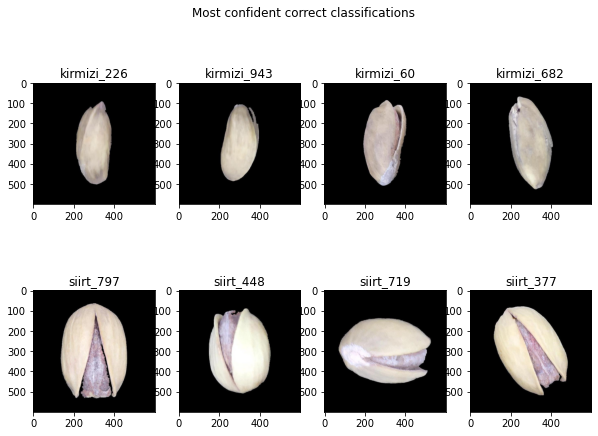

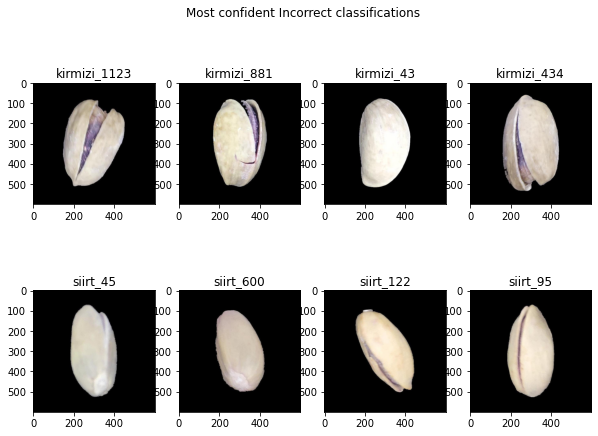

In [55]:
# Display examples images
fig, ax = plt.subplots(2,4, figsize = (10, 7))

for i in range(4):
    ax[0,i].imshow(images[correct_0_index[i]])
    ax[0,i].set_title(csv.filename_camelcase[correct_0_index[i]][:-4]) 
    
for i in range(4):
    ax[1,i].imshow(images[correct_1_index[i]])
    ax[1,i].set_title(csv.filename_camelcase[correct_1_index[i]][:-4]) 
    
plt.suptitle('Most confident correct classifications')

    
fig, ax = plt.subplots(2,4, figsize = (10, 7))
    
for i in range(4):
    ax[0,i].imshow(images[incorrect_0_index[i]])
    ax[0,i].set_title(csv.filename_camelcase[incorrect_0_index[i]][:-4]) 
    
for i in range(4):
    ax[1,i].imshow(images[incorrect_1_index[i]])
    ax[1,i].set_title(csv.filename_camelcase[incorrect_1_index[i]][:-4]) 
    
plt.suptitle('Most confident Incorrect classifications')


- It seems like the model is most confident in classifying type 0 (Kirmizi) pistachios that have a small size, and type 1 (Siirt) pistachios that have the largest size. Conversely, it incorrectly classifies large type 0 and small type 1 pistachios wrongly.

- The most confident correctly classified type 0 pistachios also seem to have a darker/dull shell and the most confident correctly classified type 1 pistachios have a bright shell color. This may be another one of the features that informs the classification.

### SVM Model 

In [56]:
from sklearn import svm
# kernel{‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’} 
# init and fit rbf svc model to train PCA data
rbf_clf = svm.SVC(kernel='rbf')
rbf_clf.fit(X_train, y_train)
# print validation scores and classification metrics
rbf_validation_score = rbf_clf.score(X_val, y_val)
# continue for other kernels
lin_clf = svm.SVC(kernel='linear')
lin_clf.fit(X_train, y_train)
lin_validation_score = lin_clf.score(X_val, y_val)
poly_clf = svm.SVC(kernel='poly')
poly_clf.fit(X_train, y_train)
poly_validation_score = poly_clf.score(X_val, y_val)
sig_clf = svm.SVC(kernel='sigmoid')
sig_clf.fit(X_train, y_train)
sig_validation_score = sig_clf.score(X_val, y_val)
print(f'Accuracy of rbf svm classifier on validation set: {round(rbf_validation_score*100,2)}%. \n Accuracy of linear svm classifier on validation set: {round(lin_validation_score*100,2)}%. \n Accuracy of poly svm classifier on validation set: {round(poly_validation_score*100,2)}%. \n Accuracy of sigmoid svm classifier on validation set: {round(sig_validation_score*100,2)}%.')

Accuracy of rbf svm classifier on validation set: 85.53%. 
 Accuracy of linear svm classifier on validation set: 80.88%. 
 Accuracy of poly svm classifier on validation set: 82.17%. 
 Accuracy of sigmoid svm classifier on validation set: 76.49%.


In [57]:
# leverage our best model parameters (linear kernel) as the classifier
clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train)
# print training and validation scores and classification metrics
training_score = clf.score(X_train, y_train)
validation_score = clf.score(X_val, y_val)
print('Accuracy of rbf svm classifier on validation set: {:.3f} (training {:.3f})'.format(validation_score, training_score))
y_pred = clf.predict(X_val)
print(metrics.classification_report(y_val, y_pred))

Accuracy of rbf svm classifier on validation set: 0.855 (training 0.868)
              precision    recall  f1-score   support

           0       0.88      0.89      0.88       238
           1       0.82      0.81      0.81       149

    accuracy                           0.86       387
   macro avg       0.85      0.85      0.85       387
weighted avg       0.85      0.86      0.86       387



- Our SVM model has a 85.5% accuracy on the validation set after hyperparameter tuning. The precision scores are similar, but recall for type 0 was noticeably higher, meaning the nut of type 0 was more often identified as a nut of type 0 and of all nuts classified as type 0 89% of them were type 0. This makes sense because there were more type 0 nuts in the dataset. 
- The SVM model performed with higher accuracy than the logistic regression model (plus ~4% accuracy).

### Models including CNN features

In [58]:
# combine hand coded PCA features with cnn PCA features after both had dimensions reduced
X_train_with_cnn = np.hstack([X_train, X_train_cnn])
X_val_with_cnn = np.hstack([X_val, X_val_cnn])
X_test_with_cnn = np.hstack([X_test, X_test_cnn])

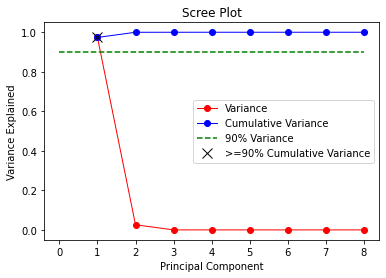

In [59]:
# use standard scaler to rescale by running fit and transform cnn train features
X_train_cnn = scaler.fit_transform(X_train_cnn)
# apply the same transform to val and test
X_val_cnn = scaler.transform(X_val_cnn)
X_test_cnn = scaler.transform(X_test_cnn)

# define PCA model to use on cnn features
n = 8
pca = PCA(n_components=n)

# fit PCA model
X_train_cnn = pca.fit_transform(X_train_cnn)
# get cumulative sum of variance and find the dimensions cutoff where we first reach >= 90% variance
cum_sum = np.cumsum(pca.explained_variance_ratio_)
cutoff = np.argwhere(cum_sum >= 0.9)[0][0] + 1

# plot scree plot with variance, cumulative variance, and cutoff
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=1, color='red', label="Variance")
plt.plot(PC_values, cum_sum, 'o-', linewidth=1, color='blue', label="Cumulative Variance")
plt.plot([0, n], [0.9, 0.9], "g--", label="90% Variance")
plt.plot(cutoff, cum_sum[cutoff - 1], "kx", label=">=90% Cumulative Variance", markersize=10)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.legend()
plt.show()

# limit train, val, and test cnn PCA features up to the first cutoff dimensions
X_train_cnn = X_train_cnn[:, :cutoff]
X_val_cnn = pca.transform(X_val_cnn)[:, :cutoff]
X_test_cnn = pca.transform(X_test_cnn)[:, :cutoff]

In [60]:
np.set_printoptions(linewidth=np.inf)
# Looking at which features contribute most to the first PCA component
ind = np.flip((np.argsort(np.abs(pca.components_[0,:]))))

print('Features that contribute the most to 1st PCA component:')
print((X_train_columns_cnn[ind[:5]]).values)
print('')
# TODO: should we delete

Features that contribute the most to 1st PCA component:
['7' '3' '6' '4' '1']



Of the 8 CNN PCA features, we only needed 1 to explain 90% of variance. Although there's limitations to running PCA on the CNN features. We can see that there's limited explainability in the features that contribute most to the first PCA components.

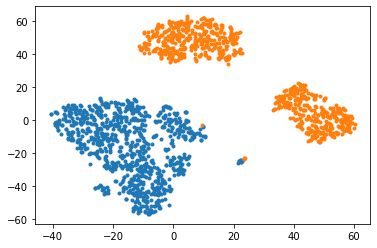

In [61]:
# use tSNE to plot combined features after PCA dimensionality reduction in 2D
tsne = TSNE(n_components=2, random_state=0)
# rescale combined train PCA data so tSNE can treat dimensions with equal importance
tsne_X_with_cnn = tsne.fit_transform(scaler.fit_transform(X_train_with_cnn))
# plot tSNE of rescaled combined train PCA data
tsne_plot_with_cnn_x = tsne_X_with_cnn[:, 0]
tsne_plot_with_cnn_y = tsne_X_with_cnn[:, 1]
check_x_with_cnn_0 = tsne_plot_with_cnn_x[y_train == 0]
check_y_with_cnn_0 = tsne_plot_with_cnn_y[y_train == 0]
check_x_with_cnn_1 = tsne_plot_with_cnn_x[y_train == 1]
check_y_with_cnn_1 = tsne_plot_with_cnn_y[y_train == 1]
plt.plot(check_x_with_cnn_0, check_y_with_cnn_0, ".")
plt.plot(check_x_with_cnn_1, check_y_with_cnn_1, ".")

- From the TSNE visualization of the first PCA components, we see that there a clear separation between the two classes. Pistachio type 0 tends to be near the lower left corner of the plot while, pistachio type 1 tends to be at the upper right corner. There is minimal overlap along the center and few images that seem to be in the "wrong" cluster (i.e., orange in the blue section or blue in the orange section).

In [62]:
# init and fit logistic regression model to combined train PCA data
logreg = LogisticRegression(penalty = 'l2', solver = 'saga')
logreg.fit(X_train_with_cnn, y_train)

# print training and validation scores and classification metrics
training_score = logreg.score(X_train_with_cnn, y_train)
validation_score = logreg.score(X_val_with_cnn, y_val)
print('Accuracy of logistic regression classifier on validation set: {:.3f} (training {:.3f})'.format(validation_score, training_score))
y_pred = logreg.predict(X_val_with_cnn)
print(metrics.classification_report(y_val, y_pred))

Accuracy of logistic regression classifier on validation set: 0.997 (training 0.998)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       238
           1       0.99      1.00      1.00       149

    accuracy                           1.00       387
   macro avg       1.00      1.00      1.00       387
weighted avg       1.00      1.00      1.00       387



With the CNN features added to our dataset, the Logistic regression model has a validation accuracy of 99.7%, a ~18% increase from the logistic regression model that didn't use CNN features.

In [63]:
# init and fit rbf svc model to combined train PCA data
clf = svm.SVC(kernel='rbf')
clf.fit(X_train_with_cnn, y_train)

# print training and validation scores and classification metrics
training_score = clf.score(X_train_with_cnn, y_train)
validation_score = clf.score(X_val_with_cnn, y_val)
print('Accuracy of linear svm classifier on validation set: {:.3f} (training {:.3f})'.format(validation_score, training_score))
y_pred = clf.predict(X_val_with_cnn)
print(metrics.classification_report(y_val, y_pred))

Accuracy of linear svm classifier on validation set: 0.997 (training 0.999)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       238
           1       0.99      1.00      1.00       149

    accuracy                           1.00       387
   macro avg       1.00      1.00      1.00       387
weighted avg       1.00      1.00      1.00       387



The SVM linear model accuracy increased by ~15% when we included the CNN features. The model also correctly classified 99% of test datapoints.

Given that our SVM and Logistic Regression models have the same accuracy on the validation set, we'll run both models with our trian datasets to assess performance

In [64]:
test_logreg_score = logreg.score(X_test_with_cnn, y_test)
print('Accuracy of logistic regression classifier on test set: {:.3f}'.format(test_logreg_score))
y_pred = logreg.predict(X_test_with_cnn)
print(metrics.classification_report(y_test, y_pred))

Accuracy of logistic regression classifier on test set: 0.991
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       122
           1       0.99      0.99      0.99        93

    accuracy                           0.99       215
   macro avg       0.99      0.99      0.99       215
weighted avg       0.99      0.99      0.99       215



In [65]:
test_svm_score = clf.score(X_test_with_cnn, y_test)
print('Accuracy of linear svm classifier on test set: {:.3f}'.format(test_svm_score))
y_pred = clf.predict(X_test_with_cnn)
print(metrics.classification_report(y_test, y_pred))

Accuracy of linear svm classifier on test set: 0.995
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       122
           1       1.00      0.99      0.99        93

    accuracy                           1.00       215
   macro avg       1.00      0.99      1.00       215
weighted avg       1.00      1.00      1.00       215



Our SVM model performed 0.4% better on our test data than the logistic regression model at an accuracy of 99.5%

### Classification Discussion
- PCA was leveraged to compress our large amount of features, which reduced the dimensionality of the data. Additionally PCA helped denoise our data and simplified our hand coded features into 6 main principle components and CNN features into 1 main principle component. Drawbacks of leveraging PCA include low interpretability of principal components. When we discussed what features were included within certain principle components, occasionally shape & color data were leveraged for a single componenet, making the actual reasoning behind a single component less simple to understand. Additionally with dimensionality reduction, there's always a chance of information loss in our data. However, our model accuracy seemed to show that it was not that large of an issue. Lastly, PCA assumes correlation between features, which for some features, for example our shape-related features, there definitely was correlation. That being said for a shape feature and a color feature, we would assume less correlation. 
- TSNE worked very well with our data. It used a Gaussian kernel to define a soft border between data points. When modeling low dimensional coordinates, it weighted close and far datapoints at equal importances, which allowed us to represent our data in a properly weighted manner, finding key differences between features. Some drawbacks of using TSNE included how long it takes and how it is not a representation.  Therefore, it is limited mostly to visualization.

### Generalizability Discussion
- We leveraged train data sets to train the initial model and validation data sets to perform hyperparameter tuning for both the Logistic Regression and SVM models. The test set was leveraged to determine final accuracy, while ensuring generalizability. In the future, our training process of the data could be improved by leveraging more data or an equal number of both types of nuts. This would allow the precision and recall of each nut type to be more similar. Overall, our model did a great job classifying the data and performed very well with the test data set, proving that our model's generalizability is strong.

### Conclusion
- In conclusion, we leveraged manual and CNN feature extraction of images to perform classification on two types of pistachios. We leveraged Logistic Regression and SVM models to classify the 2 types of nuts. The SVM model performed the best of all models, with a 85.5% accuracy on our features that didn't include CNN features, and 99.5% accuarcy on the features including manually extracted and CNN features. Through our TSNE analysis we saw that some training data had features that reflected the opposite class, but overall, there was a clear division between our data for each type of pistachio. In the future, we would continue to leverage PCA and TSNE to identify our best features and a logistic regression model to classify the data. However, we want to state that with PCA and TSNE, there is potential for data loss and with our CNN data we also identified limitations of explainability. Additionally, classification of Type 0 nuts had greater precision and recall than Type 1 nuts. In a future study, we would like to ensure the training set has equal representation of each type of nut and determine if that would improve our model's precision and recall scores. 

## References

[1] Pistachio Image Dataset https://www.kaggle.com/datasets/muratkokludataset/pistachio-image-dataset

[2] SINGH D, TASPINAR YS, KURSUN R, CINAR I, KOKLU M, OZKAN IA, LEE H-N., (2022). Classification and Analysis of Pistachio Species with Pre-Trained Deep Learning Models, Electronics, 11 (7), 981. https://doi.org/10.3390/electronics11070981. (Open Access)